# The Yelp Star Predicter

## The dataset

Yelp dataset challenge

- 1.6M reviews and 500K tips by 366K users for 61K businesses

- 481K business attributes

- social network of 366K users

- 3 datasets


## Part 1: Preparation



- JSON - but no JSON


- Solution: looping through each line to make it into a csv


- Importing into a PostgreSQL database (Amazon Server)


# Part 2: Refinery

- accessing the datasets through PostgreSQL

In [5]:
import psycopg2

con = psycopg2.connect(database="utility", user="lede",password="columbia", host="utility.c1erymiua9dx.us-east-1.rds.amazonaws.com")
cur = con.cursor()

cur.execute("SELECT * FROM lede.yelp_review LIMIT 10")
cur.fetchone()

("{u'funny': 0, u'useful': 0, u'cool': 0}",
 'aJeQbvD9rEpmfHMvw3cF_g',
 '5hhJc35OX1Ykqs3wLbXX5g',
 'Market Grille represents everything that you could ask for in a restaurant. Quality food, nice ambience, great service and good value.Although the emphasis is on Greek specialties, the mix can satisfy almost anyone, especially now that Italian food is available. If you are looking for burgers and pizza, grow up, get over it and try something different. The soups are extraordinary especially the Mushroom Pumpkin flavored with cinnamon. For desert you will find the best rice pudding along with the most delicious Baklava Cheesecake anywhere. This is an old style family enterprise and it shows. One suggestion........go there hungry.......trust me.',
 '2Fn5-x5IX7CfhCKFYaZGyA',
 5,
 '2014-12-13',
 'review',
 0,
 0,
 0)

- defining the columns


In [6]:
con.rollback()
cur.execute("Select * FROM lede.yelp_review LIMIT 1")
rcols = [d[0] for d in cur.description]

con.rollback()
cur.execute("Select * FROM lede.yelp_business LIMIT 1")
bcols = [d[0] for d in cur.description]

con.rollback()
cur.execute("Select * FROM lede.yelp_user LIMIT 1")
ucols = [u[0] for u in cur.description]

cols = [ "r."+c  for c in rcols ] + [ "b."+c  for c in bcols  if c not in rcols ] + ["u."+ u for u in ucols if u not in rcols and u not in bcols]
#cols = "r.*,"+",".join( [ "b."+c  for c in bcols  if c not in rcols ] )
cols

['r.votes',
 'r.user_id',
 'r.review_id',
 'r.review_text',
 'r.business_id',
 'r.stars',
 'r.review_date',
 'r.review_type',
 'r.votes_funny',
 'r.votes_cool',
 'r.votes_useful',
 'b.city',
 'b.review_count',
 'b.business_name',
 'b.neighborhoods',
 'b.bus_type',
 'b.full_address',
 'b.hours',
 'b.state',
 'b.longitude',
 'b.latitude',
 'b.attributes',
 'b.open',
 'b.categories',
 'u.index_num',
 'u.average_stars',
 'u.compliments',
 'u.elite',
 'u.fans',
 'u.friends',
 'u.user_name',
 'u.type_acccount',
 'u.yelping_since']

- Merging 3 datasets using SQL

In [ ]:
con.rollback()
cur.execute("DROP TABLE yelp_predict2")
cur.execute(
    "CREATE TABLE yelp_predict2 AS (SELECT "+",".join( cols )+" FROM lede.yelp_review r INNER JOIN lede.yelp_business b ON r.business_id = b.business_id INNER JOIN lede.yelp_user u ON u.user_id = r.user_id WHERE b.city = 'Las Vegas') "
)
con.commit()

In [ ]:
con.rollback()
cur.execute("SELECT * FROM yelp_predict2 LIMIT 10")
firstten = list(cur)
import pandas as pd
yelp_complete = pd.DataFrame(firstten,columns=cols)
yelp_complete

- we just want the restaurants

In [ ]:
con.rollback()

cur.execute("SELECT * FROM yelp_predict2 WHERE ('Restaurants' = any(categories));")

vegas = list(cur)
import pandas as pd
vegasdf = pd.DataFrame(vegas,columns=cols)

- write to a csv

In [ ]:
vegasdf.to_csv("vegas_restaurants_test.csv")



# EDA

In [38]:
import pandas as pd
import csv


with open('vegas_restaurants_train_small.csv', 'rU') as ourfile:
    ourlist = list( csv.DictReader(ourfile) ) 
    
vegas = pd.DataFrame(ourlist)

reviews = vegas["r.review_text"]
stars = vegas["r.stars"]

In [2]:
vegas.head()

,,b.attributes,b.bus_type,b.business_name,b.categories,b.city,b.full_address,b.hours,b.latitude,b.longitude,...,r.votes_useful,u.average_stars,u.compliments,u.elite,u.fans,u.friends,u.index_num,u.type_acccount,u.user_name,u.yelping_since
0,0,"{""Take-out"": true, ""Accepts Credit Cards"": tru...",business,Earl of Sandwich,"['Sandwiches', 'Restaurants']",Las Vegas,3667 Las Vegas Blvd. S.\nPlanet Hollywood Reso...,"{""Monday"": {""close"": ""00:00"", ""open"": ""00:00""}...",36.1102659929599,-115.170553265095,...,4,3.73,"{""funny"": 3, ""plain"": 4, ""writer"": 3, ""list"": ...",[2008],8,"['y4F30s5qp4VBInqmt4Upyg', 'AaZdXn0I6F5bdIVwGp...",,user,Vanessa,2006-09
1,1,"{""Take-out"": true, ""Accepts Credit Cards"": tru...",business,Earl of Sandwich,"['Sandwiches', 'Restaurants']",Las Vegas,3667 Las Vegas Blvd. S.\nPlanet Hollywood Reso...,"{""Monday"": {""close"": ""00:00"", ""open"": ""00:00""}...",36.1102659929599,-115.170553265095,...,0,3.58,"{""plain"": 1, ""hot"": 1}",[],0,"['WmAyExqSWoiYZ5XEqpk_Uw', 'UuZjstcJYy8vi84wzY...",,user,Justin,2009-06
2,2,"{""Take-out"": true, ""Accepts Credit Cards"": tru...",business,Earl of Sandwich,"['Sandwiches', 'Restaurants']",Las Vegas,3667 Las Vegas Blvd. S.\nPlanet Hollywood Reso...,"{""Monday"": {""close"": ""00:00"", ""open"": ""00:00""}...",36.1102659929599,-115.170553265095,...,1,3.82,"{""profile"": 8, ""funny"": 56, ""plain"": 120, ""wri...","[2010, 2011, 2012, 2013, 2014, 2015]",52,"['zTWH9b_ItSdLOK9ypeFOIw', 'LroJKi7_BWqDT7lbHv...",,user,Rob,2008-01
3,3,"{""Take-out"": true, ""Accepts Credit Cards"": tru...",business,Earl of Sandwich,"['Sandwiches', 'Restaurants']",Las Vegas,3667 Las Vegas Blvd. S.\nPlanet Hollywood Reso...,"{""Monday"": {""close"": ""00:00"", ""open"": ""00:00""}...",36.1102659929599,-115.170553265095,...,2,3.79,"{""profile"": 49, ""funny"": 261, ""cute"": 24, ""pla...","[2010, 2011, 2012, 2013, 2014, 2015]",87,"['rpOyqD_893cqmDAtJLbdog', 'zTWH9b_ItSdLOK9ype...",,user,Jade,2009-04
4,4,"{""Take-out"": true, ""Accepts Credit Cards"": tru...",business,Earl of Sandwich,"['Sandwiches', 'Restaurants']",Las Vegas,3667 Las Vegas Blvd. S.\nPlanet Hollywood Reso...,"{""Monday"": {""close"": ""00:00"", ""open"": ""00:00""}...",36.1102659929599,-115.170553265095,...,0,3.75,"{""profile"": 1, ""funny"": 23, ""cute"": 4, ""plain""...","[2009, 2010, 2011]",4,"['GJYJX4SujVj3BR8v2F9PDQ', 'w6Vv-kldGpmvSGqXvT...",,user,Jeffrey,2007-12


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
stars = vegas["r.stars"]
stars2 = stars.apply( lambda x: int(x)) # if x else -1
#stars2[ stars2.notnull() ]

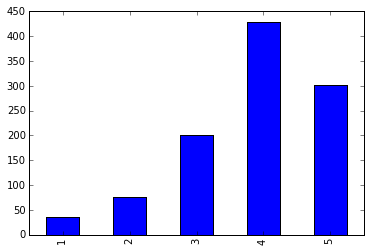

In [32]:
stars2.value_counts().sort_index().plot(kind="bar")

# Wordclouds!

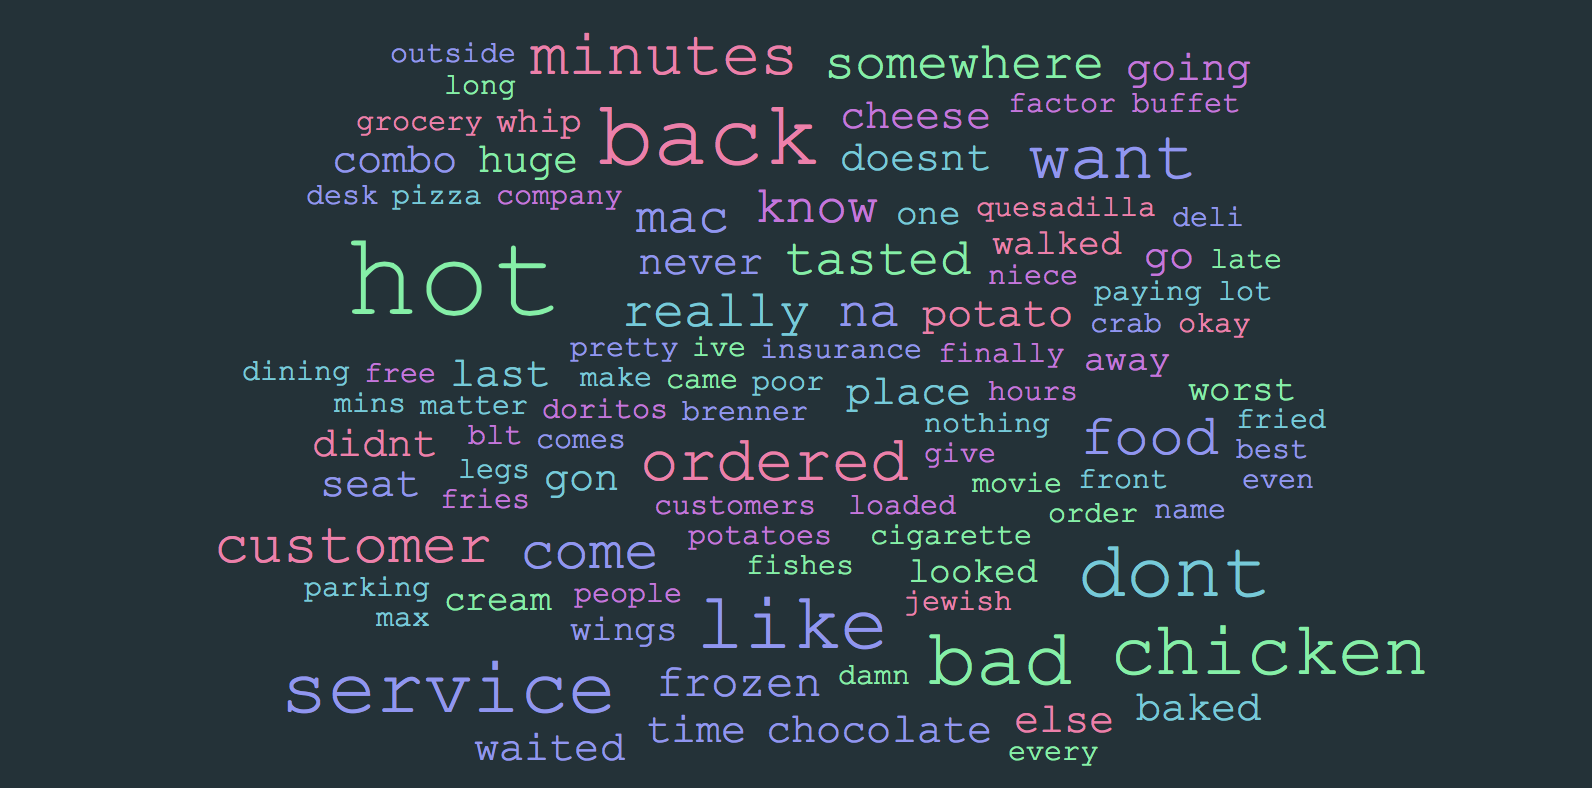

In [49]:
from IPython.display import Image
Image(filename='wordcloud.png') # 1 star reviews

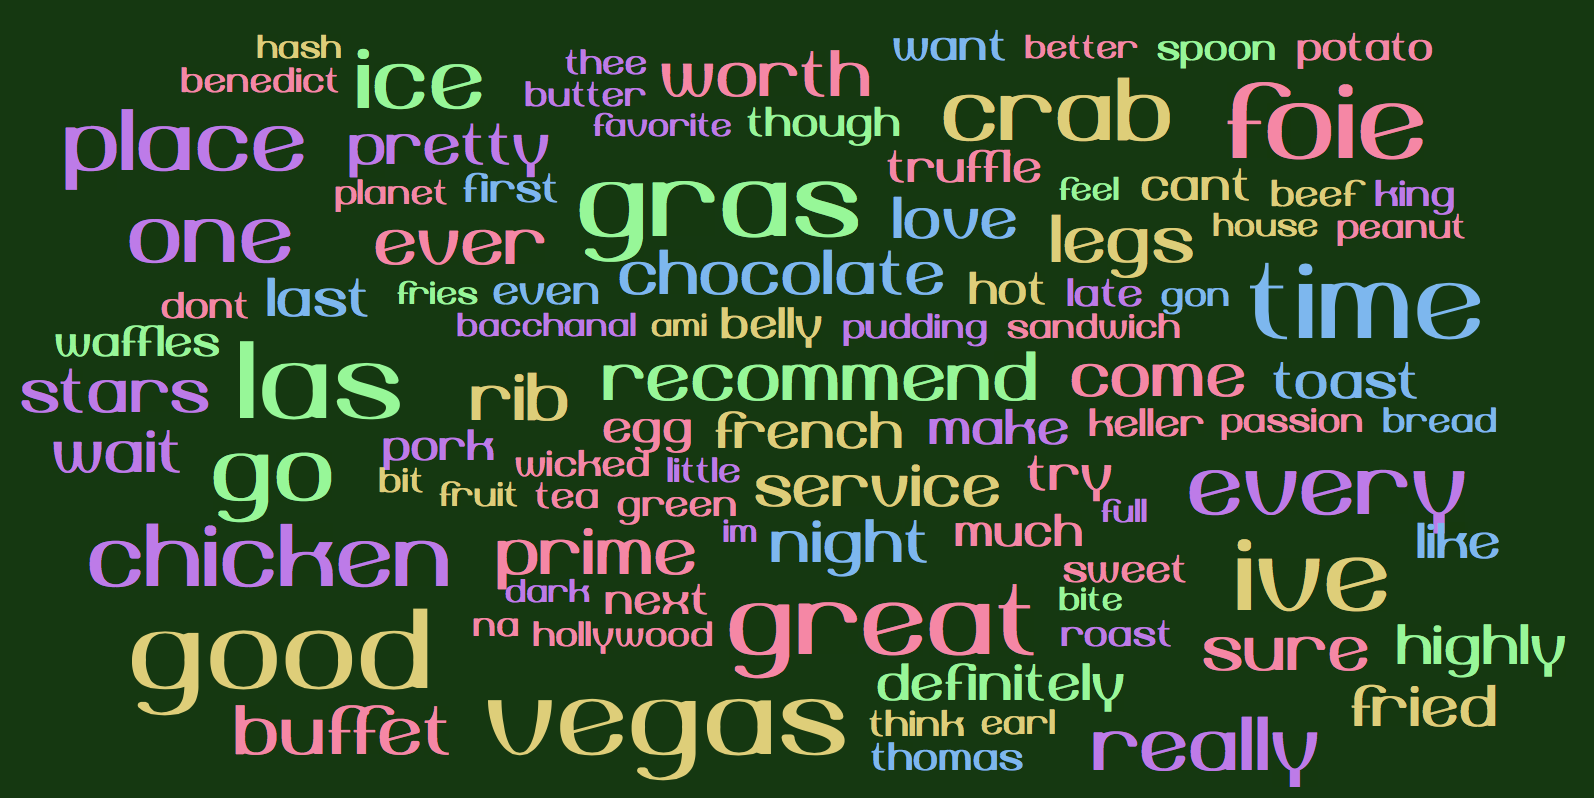

In [53]:
from IPython.display import Image
Image(filename='wordcloud2.png') # 5 star reviews

# Machine Learning 

In [46]:
from sklearn import preprocessing
from sklearn import cross_validation
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from textblob import TextBlob 

# Decision Tree Classification

## VECTORIZING

In [40]:
encoder = preprocessing.LabelEncoder()
correct_labels = encoder.fit_transform(stars)

vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2))
data = vectorizer.fit_transform(reviews).todense()

print data
print data.shape

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
(1043, 87619)


## MODEL BUILDING

In [41]:
model = DecisionTreeClassifier()
fit_model = model.fit(data, correct_labels)

scores = cross_validation.cross_val_score(model, data, correct_labels, cv=4)
print "Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)

Accuracy: 0.37 (+/- 0.06)


## TESTING THE MODEL


In [44]:
review1 = ["After reading all the reviews here, I decided to go and try these sandwiches. Unfortunately, I\'m not sure what the fuss is about. These sandwiches are a step above Subway, but I wouldn\'t say incredibly delicious. They are pretty average and what makes them different is the bread. Their bread is partially baked and it\'s finished after the order is taken and it goes through their special toaster with all the ingredients on top. Smaller than your average Subway, but it does the job of killing your hunger. Their frozen lemonade on the other hand, is worth trying. A little bit on the sweet size, but good. \n\nWe ordered the meatball sandwich, and the meatballs were moist and pretty good. I wouldn\'t say excellent, though. I have tried better ones at other places like Philadelphia! The BLT was delicious and I would definitely recommend it. I ordered a chicken soup, just to try something else as well, and this soup would be recommended for someone with a hangover who will not know the difference between quality and quantity. Not a soup, but closer to a gravy! YUK!\n\nWill I return to Earl of Sandwich, perhaps but only for their BLT and frozen lemonade. I was not taken by anything that will give them the name of spectacular sandwiches, just a cut above average."]

In [45]:
testdata = vectorizer.transform(review1)
print '%s -> %s' % (str(review1), encoder.classes_[model.predict(testdata)])

["After reading all the reviews here, I decided to go and try these sandwiches. Unfortunately, I'm not sure what the fuss is about. These sandwiches are a step above Subway, but I wouldn't say incredibly delicious. They are pretty average and what makes them different is the bread. Their bread is partially baked and it's finished after the order is taken and it goes through their special toaster with all the ingredients on top. Smaller than your average Subway, but it does the job of killing your hunger. Their frozen lemonade on the other hand, is worth trying. A little bit on the sweet size, but good. \n\nWe ordered the meatball sandwich, and the meatballs were moist and pretty good. I wouldn't say excellent, though. I have tried better ones at other places like Philadelphia! The BLT was delicious and I would definitely recommend it. I ordered a chicken soup, just to try something else as well, and this soup would be recommended for someone with a hangover who will not know the differ

# Random Forest

In [ ]:
to be continued....

# Why could this be useful?


- helps Yelp verifying the reviews 


- allows further investigations 

# FURTHER IDEAS

- predicting the gender based on the review


- word analysis -> which words are related to which grading? is "good" more a 4 stars or a 5 stars grading?


- normalizing the grading -> how are text and stars grading related? Could grumpy reviews be filtered?


- psychological researches: are people more generous if they write a text? Or are they more generous if the have to decide for a stars grading?


- what's more accurate: review text or stars grading?